In [1]:
from libraries import lib
from libraries.NeuralStates import *
import torch.nn as nn 
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def log_amp_phase(nn_output):
    return torch.exp(nn_output[:, 0] + 1.j * nn_output[:, 1])

def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x

# only for nn_output = (log(amp), phase)
def generate_eloc_distr(sampled_vector, N, J, Gamma, model):
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output
    
    eloc_values = {}
    for basis_state in sampled_vector.distribution:
        eloc = 0
        output = model_to_output(basis_state)
        for adjacency in lib.generate_adjacencies(basis_state, N):
            output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_prime[0] - output[0] + 1.j * 2 * np.pi * (output_prime[1] - output[1]))
        eloc_values[basis_state] = eloc
    return eloc_values

In [11]:
N=6; J=1; h=1

In [16]:
layers = []
layers.append(nn.Linear(N, 32))
for _ in range(2):
    layers.append(nn.Linear(32, 32))
    layers.append(nn.SELU())
layers.append(nn.Linear(32, 2))
model = nn.Sequential(*layers)

In [17]:
def generate_input_samples(N, samples):
    return torch.tensor([lib.generate_state_array(x, N) for x in samples]).to(torch.float32)

In [18]:
num_epochs = 1000
data_rate = 1
num_samples = 256
epochs = []
energy_data = []

optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    eloc_distr = generate_eloc_distr(mh_state, N, J, h, model)
    eloc_list = torch.tensor([eloc_distr[x] for x in mh_state.list])
    psi = model(generate_input_samples(N, mh_state.list))
    log_amp = psi[:, 0]; phase = psi[:, 1]
    eloc_r = eloc_list.real
    eloc_i = eloc_list.imag
    energy = eloc_r.mean()
    loss = ((eloc_r - eloc_r.mean()).detach() * log_amp + (eloc_i - eloc_i.mean()).detach() * phase).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
       print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-5.3583) 0.06612665206193924
1 tensor(-6.2027) 0.004699272103607655
2 tensor(-5.9327) -0.01086498610675335
3 tensor(-5.9609) 0.0037226099520921707
4 tensor(-5.7071) -0.0013794002588838339
5 tensor(-5.9866) -0.04072592779994011
6 tensor(-5.9157) -0.03527946025133133
7 tensor(-5.9472) 0.03865468129515648
8 tensor(-5.9153) -0.004421355202794075
9 tensor(-6.0619) -0.054123301059007645
10 tensor(-5.8157) -0.07212834060192108
11 tensor(-6.1197) -0.06373695284128189
12 tensor(-6.3050) -0.10346006602048874
13 tensor(-5.9106) -0.026951579377055168
14 tensor(-6.0776) -0.12940895557403564
15 tensor(-6.2192) -0.1101684495806694
16 tensor(-5.9337) 0.015674777328968048
17 tensor(-6.2341) -0.12631894648075104
18 tensor(-6.0564) 0.03639431297779083
19 tensor(-6.1427) -0.07716730982065201
20 tensor(-6.1623) -0.07787095010280609
21 tensor(-6.3690) -0.23842547833919525
22 tensor(-6.2116) -0.38821151852607727
23 tensor(-6.4113) -0.3282553553581238
24 tensor(-6.7898) -0.38583311438560486
25 tensor

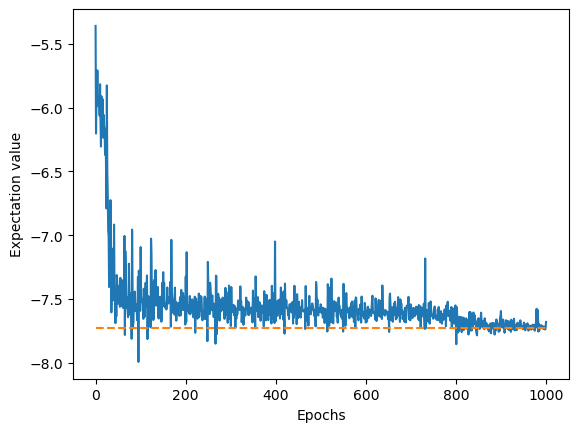

In [19]:
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [lib.ground_state_energy(h, N)] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [20]:
np.array(energy_data[900:]).std()

np.float64(0.032090897711979954)

In [31]:
def update_gradients(model, lr):
    with torch.no_grad():
        for p in model.parameters():
            p -= lr * p.grad 

In [32]:
N=20; J=1; h=1

In [64]:
layers = []
layers.append(nn.Linear(N, 32))
for _ in range(2):
    layers.append(nn.Linear(32, 32))
    layers.append(nn.SELU())
layers.append(nn.Linear(32, 2))
model = nn.Sequential(*layers)

num_epochs = 500
data_rate = 1
num_samples = 128#
epochs = []
energy_data = []

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 0, num_samples)
    eloc_distr = generate_eloc_distr(mh_state, N, J, h, model)
    eloc_list = torch.tensor([eloc_distr[x] for x in mh_state.list])
    psi = model(generate_input_samples(N, mh_state.list))
    log_amp = psi[:, 0]; phase = psi[:, 1]
    eloc_r = eloc_list.real
    eloc_i = eloc_list.imag
    energy = eloc_r.mean()
    loss = ((eloc_r - eloc_r.mean()).detach() * log_amp + (eloc_i - eloc_i.mean()).detach() * phase).mean()
    optimizer.zero_grad()
    loss.backward()
    # update_gradients(model, 0.01)
    # update_gradients(model, [0.001, 0.0001][energy < -24])
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
       print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-19.3873) 0.09636660665273666
1 tensor(-19.3533) 0.15325267612934113
2 tensor(-21.2377) 0.3370091915130615
3 tensor(-20.9659) 0.17353031039237976
4 tensor(-22.3484) 0.18907718360424042
5 tensor(-19.9392) 0.1553260236978531
6 tensor(-19.1838) 0.04562319815158844
7 tensor(-21.1549) -0.011914042755961418
8 tensor(-21.5308) 0.0022670836187899113
9 tensor(-20.5127) -0.003521796315908432
10 tensor(-22.4204) 0.07811692357063293
11 tensor(-19.8542) -0.04307252913713455
12 tensor(-21.7460) 0.24790096282958984
13 tensor(-19.7141) -0.06031039357185364
14 tensor(-18.9242) 0.12410438060760498
15 tensor(-20.2855) -0.06715439260005951
16 tensor(-21.6506) 0.03843045234680176
17 tensor(-21.0249) -0.09728685766458511
18 tensor(-22.4063) 0.025707464665174484
19 tensor(-18.8286) -0.05225975438952446
20 tensor(-21.0140) -0.06119631975889206
21 tensor(-22.0261) -0.02672472968697548
22 tensor(-20.3144) 0.0778224915266037
23 tensor(-22.6362) 0.02396518364548683
24 tensor(-20.7283) 0.01078540086746215

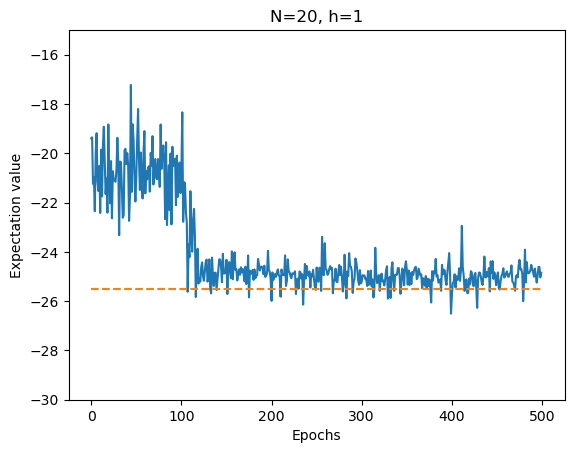

In [66]:
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [lib.ground_state_energy(h, N)] * 2, linestyle = '--')
plt.title('N=20, h=1')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.ylim(-30, -15)
plt.show()

In [67]:
np.array(energy_data[200:]).std()

np.float64(0.42138900544688696)

In [68]:
mh_state.distribution

{0: 64, 32768: 44, 33280: 13, 1024: 7}

In [69]:
model(generate_input_samples(N, mh_state.list))

tensor([[ 2.0060, -0.0737],
        [ 2.0060, -0.0737],
        [ 2.0060, -0.0737],
        [ 2.0060, -0.0737],
        [ 2.0060, -0.0737],
        [ 2.0060, -0.0737],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 2.0060, -0.0737],
        [ 2.0060, -0.0737],
        [ 2.0060, -0.0737],
        [ 2.0060, -0.0737],
        [ 2.0060, -0.0737],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0.0859],
        [ 0.6263, -0